In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def one_hot_encoding_1D(sequences):
    """Perform one hot encoding on DNA sequences.
    sequences is a list of DNA sequences.
    Returns a numpy array of the shape (number_of_sequences, max_len, 4).
    This is compatible as input for 1D CNN."""
    from keras.preprocessing.text import Tokenizer
    from keras.utils import to_categorical
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(['ACGT'])
    sequence_of_int = tokenizer.texts_to_sequences(sequences)
    one_hot_encoded = to_categorical(sequence_of_int)
    one_hot_encoded = one_hot_encoded[..., 1:]
    one_hot_reshaped = one_hot_encoded.reshape((len(sequences), 250, 4))
    return one_hot_reshaped

import sys
import os

def expression_model(params):
    from keras import layers
    from keras import models
    from keras.optimizers import Adam
    from keras.regularizers import l1_l2
    num_filters = params['num_filters']
    num_filters2 = params['num_filters2']
    kernel_size = params['kernel_size']
    kernel_size2 = params['kernel_size2']
    l1_lambda = params['l1_lambda']
    l2_lambda = params['l2_lambda']
    lr = params['lr']
    model = models.Sequential()
    model.add(layers.Conv1D(num_filters, kernel_size, input_shape=(250, 4), activation='relu',
                            kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='1st_Conv1D'))
    model.add(layers.MaxPooling1D(2, strides=1, name='1st_MaxPooling1D'))
    model.add(layers.Dropout(0.5, name='1st_Dropout'))
    model.add(layers.Conv1D(num_filters2, kernel_size2, activation='relu',
                            kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='2nd_Conv1D'))
    model.add(layers.MaxPooling1D(2, strides=1, name='2nd_MaxPooling1D'))
    model.add(layers.Dropout(0.5, name='2nd_Dropout'))
    model.add(layers.Flatten(name='Flatten'))
    model.add(layers.Dense(1, kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='Output'))
    model.compile(Adam(lr=lr), 'mse')
    return model


In [2]:
#Load dataframe of sequences to predict APA for

df = pd.read_csv("segal_variants.tab", sep='\t')


In [3]:
#Execute pA prediction model

one_hots = one_hot_encoding_1D([row['Sequence'] for _, row in df.iterrows()])

params = {
    'batch_size': 256,
    'epochs': 75,
    'kernel_size': 8,
    'kernel_size2': 6,
    'l1_lambda': 0.0001,
    'l2_lambda': 0.0001,
    'lr': 0.0015,
    'num_filters': 64,
    'num_filters2': 32
}

model = expression_model(params)
model.load_weights('SavedModels/saved_cnn_expression_model.h5')

y_pred = model.predict(x=[one_hots], batch_size=32)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


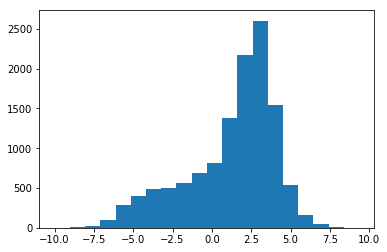

In [4]:
import matplotlib.pyplot as plt

f = plt.figure()

plt.hist(y_pred[:, 0], bins=20)

plt.show()


In [5]:
#Store predictions in df

df['iso_pred'] = 0.
df['logodds_pred'] = y_pred[:, 0]


In [6]:
#Re-save prediction df

df.to_csv("segal_variants_predictions_df_PolyApredictor.csv", sep='\t', index=False)
